<a href="https://colab.research.google.com/github/XueYang0130/1CSD1_Thesis/blob/main/2_Qflip_Random_Noise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###**Part 1 Model**

**Background:**

We assume p0 has a periodic strategy (default: start 0, period 50) with small degree of random noise, where "period" represents the time interval between two adjacent moves. For example, "prob" is the probability to add a random noise to the move period of p0, which is in the range of [0,1]. "scale" is the degree of the noise to he period e.g. in one episode the period changes from 50 to 55 after adding a noise of 5. Additionally, p1 has an adaptive strategy and p1 can observe the information of oppLM (last "known" move of opponent). 

**Reward function - 'constant_minus_cost_norm'**:
*   If there is no move this turn, reward is 0
*   Otherwise, If the most recent game move was by the agent, reward is -cost； else If the most recent game move was by the opponent, reward is (opponent move period - own move cost)/c, where c is a constant (c=5).

**Other Assumptions:**

(1) If p0 and p1 move together, p0 controls the resource, p0 still need to pay the cost;

(2) Defender's move cost is lower than attacker's move cost;

(3) At tick = 0, we assume both players move;

(4) Starting State:
  Player 0 has control at tick = 0;

(5) Episode Termination:
  tick reaches duration of game (default duration: 10000);




In [2]:
#import libraries
import numpy as np
import random 
import matplotlib.pyplot as plt

In [3]:
#define an environment class
#p0: defender, p1: attacker

class Env(object):
  def __init__(self):
    #initialization
    self.actions=[0,1]  #two actions: 0 doesn't move; 1 move 
    self.tick=0   #time tick
    self.cost=[1,5] #costs of p0 and p1 respectively
    self.period=50 #initialize the period as 50 indicating that the defender moves exactly at 50 time units after the previous move
    self.acc_period=50 #sum of all periods which have happened to p0
    self.period_list=[] #store all periods in this list
    self.c=5 #a constant for use in reward function below
    self.reward_constant_norm=(self.period-self.cost[1])/self.c # Reward function - 'constant_minus_cost_norm' described above
    self.init_state= -1 #initial state observed by the attacker/agent
    self.state = self.init_state # 'state' is the time tick since the opponent's last "known" move at time t (maybe not true last move time)
    self.p0_moves = [0] #a list of move ticks for p0
    self.p1_moves = [0] #a list of move ticks for p1
    self.duration=50000 #the maximum time detps
    self.done=False #indicates whether the game is over
    self.controller=0 #indicates who control the resource
    self.total_gain=[0,0] #the 1st element:accumulated gain of controling time of the resource for p0; the 2nd element: the accumalated gain for p1.
    self.total_cost=[1,5] #the 1st element:the accumulated cost for p0; the 2nd element: the accumulated cost for p1.
    self.p0_avr_benefit=[] #a list of the average benefits of p0 at each time tick, where avr_benefit=(total_gain-total_cost)/time_steps
    self.p1_avr_benefit=[]  #a list of the average benefits of p1 at each time tick
    self.flipping_count = 0 #how many times of "flipping" (a kind of action) that happens to p1
    self.hold_time_list = [] #a list of durations of p1 controling the resource in each period

  def step(self,action,tick,scale,prob):
    reward = 0 
    if tick==self.acc_period: #if the tick is the time that p0 should move
        self.generate_period(scale,prob) #generate a new period with random noise. Meanwhile assign values to parameter "scale" and "prob".
        self.acc_period+=self.period #update the new accumulated period
        self.period_list.append(self.period) #add period to the corresponding list
        
        #p0 and p1 move together, p0/defender will control the resource
        if action == 1:
          reward = -self.cost[1] #generate reward
          self.state += 1 #next state will be incresed by 1 given the current state
          self.total_cost[1]+=self.cost[1] #add cost to p0
        else:# p0 moves, p1 doesn't move   
          self.state += 1 #next state 
        self.p0_moves.append(tick) #update the list p0's move times
        self.controller=0 #update the controlloer
        self.total_cost[0]+=self.cost[0] #add cost to p0

    else: #if the tick is not the time that p0 should move
        if action == 1:# p1 moves, p0 doesn't move
            #flipping - p1 moves while p0 is controlling the resource
            if self.p1_moves[-1] < self.p0_moves[-1]: 
              reward = self.reward_constant_norm #generate reward
              self.state = tick - self.p0_moves[-1] +1 #next state
              self.flipping_count+=1  #update flipping count
              self.hold_time_list.append(self.p0_moves[-1]+self.period-tick) #update the hold-resource-time list for p1
            # consecutive - p1 moves while it has already controlled the resource
            elif self.p1_moves[-1] >= self.p0_moves[-1]:
              reward = -self.cost[1] #generate reward
              self.state += 1 #next state
            self.p1_moves.append(tick) #update the list of move ticks for p1
            self.total_cost[1]+=self.cost[1] #update total cost for p1
            self.controller=1 #update the controller
        else:# both hold 
            self.state += 1 #next state

    #check if the game is over
    if tick==self.duration: 
      self.done=True
    
    self.total_gain[self.controller]+=1 #update the list of the total_gain to add one time step to the controller
    self.p0_avr_benefit.append((self.total_gain[0]-self.total_cost[0])/(tick+1)) #add the new average benefit to the corresponding list for p0
    self.p1_avr_benefit.append((self.total_gain[1]-self.total_cost[1])/(tick+1)) #add the new average benefit to the corresponding list for p1

    return self.state, reward, self.done #return next state/observation, reward for the agent, and the state of 'done'
  
  #define a function to add a random noise. "scale" controlls what's the defree of the noise compared with th edefault period 50
  #"prob" indicates the probability of adding a random noise to a period.    
  def generate_period(self, scale, prob): 
      if np.random.rand()<prob: 
      #add random noise to the period
        self.period=random.choice(list(range(50-scale,50+scale+1)))
      else: #set the period as default 50
        self.period=50

  def reset(self): #reset the environment
    self.actions=[0,1]  
    self.tick=0   
    self.cost=[1,5] 
    self.period=50 
    self.acc_period=50 
    self.period_list=[] 
    self.c=5 
    self.reward_constant_norm=(self.period-self.cost[1])/self.c 
    self.init_state= -1 
    self.state = self.init_state 
    self.p0_moves = [0] 
    self.p1_moves = [0] 
    self.duration=50000 
    self.done=False 
    self.controller=0 
    self.total_gain=[0,0] 
    self.total_cost=[1,5] 
    self.p0_avr_benefit=[] 
    self.p1_avr_benefit=[]  
    self.flipping_count = 0 
    self.hold_time_list = []



In [4]:
#define an agent class for the p1/attacker
class Agent(object):
  def __init__(self,env):
    self.env=env
    #initialisation
    self.alpha = 0.3 #learning rate
    self.gamma=0.8 #discount value
    self.actions=[0,1] #actions can be chosen
    self.Q_table=np.zeros((100000,2)) #create a Q table and initialise all values to be zero
    self.cur_state=self.env.state #get the current state from the environment
    self.next_state=0 #the next state is initialised to be 0

  def do_step(self,epsilon,tick,scale,prob):
    action=self.epsilon_greedy(self.cur_state, epsilon) #select an action
    self.next_state, reward, done=self.env.step(action,tick,scale, prob)  #take the action, and get the next state, reward and the state of "done" from the environment
    self.update_Q(reward, self.cur_state, self.next_state,action) #update Q table
    self.cur_state=self.next_state #update the new current state
    return done #return the state of "done"
 
 #define epsilon greedy exploration method (epsilon decays in each episode) 
  def epsilon_greedy(self, state, epsilon): 
    if np.random.rand()<epsilon:
      return random.choice(self.actions) #select an action at random
    else:
      return np.argmax(self.Q_table[state]) #otherwise, select the action with the maximum Q value at that state given the Q table

  #update Q table given the Q-learning algorithm
  def update_Q(self, reward, cur_state, next_state, action): 
    self.Q_table[cur_state, action]=self.Q_table[cur_state, action]+self.alpha*(reward+self.gamma*np.max(self.Q_table[next_state])-self.Q_table[cur_state,action])



In [ ]:
env = Env() #create an environment object
attacker = Agent(env) #create an agent object
scales=list(range(1, 21)) #the range of scale of noise
prob=0.2 #probability of adding a random noise
final_avr_benefit_p1=[] #the final average benefit for p1 with different scale values
final_avr_benefit_p0=[] #the final average benefit for p1 with different scale values

for scale in scales: #loop for scale in {1, 2, 3, ..., 20}
  avr_benefit_p1=[]
  avr_benefit_p0=[]
  for i in range(10): #perform 10 times
    env.reset() #reset environment
    epsilon = 1 #define epsilon with an initial value of 1
    for tick in range(env.duration): 
      epsilon=max(epsilon-1/1000, 0.001) # update epsilon with decay
      attacker.do_step(epsilon,tick,scale,prob) #let the agent take step
    avr_benefit_p1.append(env.p1_avr_benefit[-1])
    avr_benefit_p0.append(env.p0_avr_benefit[-1])
    if i==9: 
      final_avr_benefit_p1.append(np.mean(avr_benefit_p1))
      final_avr_benefit_p0.append(np.mean(avr_benefit_p0))


###**Part 2 QFlip With Zero Noise**
###When there is no noise in the moving period of p0, the setting should be changed, for example, there are fewer states in the Q table, the duration can be set as a samller number, and the probability of adding a noise to the moving period for p0 should be zero. Here is an example:

* In the generate_period(margin,prob) method, the value of "prob"
is 0.
* duration=10000
* Q_table=np.zeros((100,2))



### The following move times show that QFlip with states based on the time since opponent’s last move converges to the optimal adaptive strategy: playing immediately after the opponent with the same period. In this case, the defender moves at 0, 50, 100, 150, etc. The optimal strategy for the attacker is to move right after the attcker, say, at 1, 51, 101, 151, etc.

In [14]:
print("p0:",env.p0_moves[-100:])
print("p1:",env.p1_moves[-100:])

p0: [45000, 45050, 45100, 45150, 45200, 45250, 45300, 45350, 45400, 45450, 45500, 45550, 45600, 45650, 45700, 45750, 45800, 45850, 45900, 45950, 46000, 46050, 46100, 46150, 46200, 46250, 46300, 46350, 46400, 46450, 46500, 46550, 46600, 46650, 46700, 46750, 46800, 46850, 46900, 46950, 47000, 47050, 47100, 47150, 47200, 47250, 47300, 47350, 47400, 47450, 47500, 47550, 47600, 47650, 47700, 47750, 47800, 47850, 47900, 47950, 48000, 48050, 48100, 48150, 48200, 48250, 48300, 48350, 48400, 48450, 48500, 48550, 48600, 48650, 48700, 48750, 48800, 48850, 48900, 48950, 49000, 49050, 49100, 49150, 49200, 49250, 49300, 49350, 49400, 49450, 49500, 49550, 49600, 49650, 49700, 49750, 49800, 49850, 49900, 49950]
p1: [45051, 45101, 45151, 45184, 45201, 45251, 45301, 45351, 45401, 45451, 45501, 45551, 45601, 45651, 45701, 45751, 45801, 45851, 45901, 45951, 46001, 46051, 46101, 46151, 46201, 46251, 46301, 46351, 46401, 46451, 46501, 46551, 46601, 46651, 46701, 46751, 46801, 46851, 46901, 46951, 47001, 470

### Here is a visualization of the average benefits for p0 and p1 over time, following the equation: average_benefit=(total_gain-total_cost)/t, where t=1, 2, 3, ... Given the following figure, QFlip converges and p1 maximizes its average benefit over time.

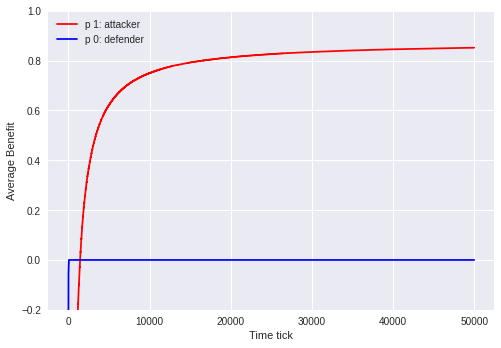

In [10]:
#visualiztaion of the change of average benefit for p0 and p1
plt.style.use('seaborn')
plt.figure()
#plt.title( "The change of average benefit for P0 and p1")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p1_avr_benefit,color = "red",label="p 1: attacker ")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p0_avr_benefit, color = "blue",label="p 0: defender")
plt.ylim(-0.2, 1)
plt.xlabel("Time tick")
plt.ylabel("Average Benefit")
plt.legend()

###Given below, when Qflit converges, the maximum controling time for the attacker is 49 time units in each period of 50 time units.

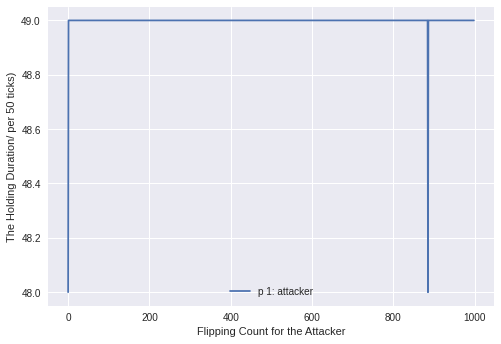

In [12]:
#visualiztaion of the duration for p1 to control the resource in each period of 50 ticks
plt.style.use('seaborn')
plt.figure()
#plt.title( "The duration for p1 to control the resource in each period of 50 ticks")
plt.plot(np.array(range(env.flipping_count)), env.hold_time_list,label="p 1: attacker")
plt.xlabel("Flipping Count for the Attacker")
plt.ylabel("The Holding Duration/ per 50 ticks)")
plt.legend()

###**Part 3 QFlip With None-zero Random Noise**
###When there are some small-degree random noises to the moving period of p0 (scale!=0, prob!=0), the setting should be changed as follows: 

*   there are more states in the Q table
*   the duration is longer
*   epsilon decays with a smaller step

###Here is an example showing the values of the parameters:
* In the generate_period(margin,prob) method, the value of "prob"
is 0.2, margin=5
* duration=100000
* Q_table=np.zeros((100000,2))
* epsilon=max(1-1/1000, 0.001)


###Visualize the Average Benefit, indicating that QFlip converges.

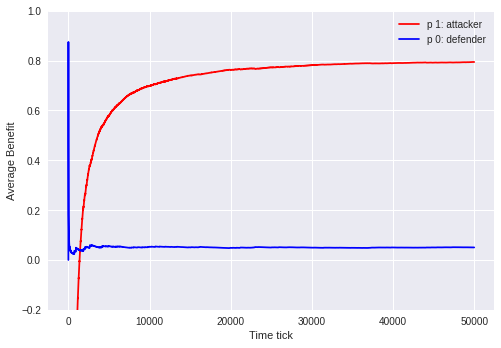

In [16]:
#visualiztaion
plt.style.use('seaborn')
plt.figure()
#plt.title( "The change of average benefit for P0 and p1")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p1_avr_benefit,color = "red",label="p 1: attacker")
plt.plot(np.array(range(len(env.p1_avr_benefit))), env.p0_avr_benefit, color = "blue",label="p 0: defender")
plt.ylim(-0.2, 1)
plt.xlabel("Time tick")
plt.ylabel("Average Benefit")
plt.legend()

### **Part 4 observe the change of average benefit based on the change of "probability" or "scale".**

In [422]:
print(final_avr_benefit_p0)
print(final_avr_benefit_p1)

[0.01901, 0.039330000000000004, 0.057940000000000005, 0.076762, 0.09506600000000001, 0.11295200000000001, 0.12958, 0.14506599999999997, 0.162912, 0.176712, 0.18861, 0.189622, 0.202292, 0.22698800000000002, 0.23059600000000002, 0.259142, 0.253602, 0.26531399999999994, 0.27830199999999994, 0.27276]
[0.833192, 0.813782, 0.795, 0.775554, 0.7568300000000001, 0.73898, 0.7220359999999999, 0.70491, 0.68727, 0.672358, 0.661014, 0.657936, 0.644678, 0.619364, 0.615506, 0.588446, 0.591498, 0.579302, 0.567276, 0.57113]


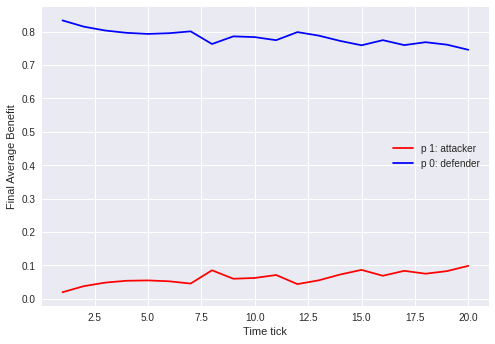

In [18]:
#Viusalize the above results given prob=(0.2, 0.4, 0.6) and scale= {1, 2, 3,...,20}
plt.style.use('seaborn')
plt.figure()
plt.plot(np.array(range(1, 21)), final_avr_benefit_p0, color = "red",label="p 1: attacker")
plt.plot(np.array(range(1, 21)), final_avr_benefit_p1, color = "blue",label="p 0: defender")
#plt.ylim(-0.2, 1)
plt.xlabel("Time tick")
plt.ylabel("Final Average Benefit")
plt.legend()

**Result**
*   By varying the value of scale from 1 to 20 given the same probability, the result shows that the average benefit for p0 decreases and the average benefit for p1 increases.
*   Besides, by trying probability with different values (e.g. 0.2, 0.4, 0.6), we found that the larger the probability, the faster the average benefit changes for p0 and p1.

